In [1]:
import numpy as np
import copy
import sys
import scipy
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.optimize import curve_fit
from scipy.stats import unitary_group
import time as t
import matplotlib.pyplot as plt
np.set_printoptions(precision=2, linewidth=100)

#this method takes ~5.8 seconds per tpoint drealization at N = 100,000
#vs 1.74 seconds using the other method, so approximately 3-4x slower
#this is kind of expected since you do an extra matrix multiplication and an inverse
def generateTmat(U, e=0, d=None):
    #give me the unitary for the evolution of two neighboring unit cells, U
    #give me a quasieigenvalue
    if d == None:
        d = len(U)//2
    eqns = U - np.exp(-1j*e)*np.eye(2*d,dtype=complex)
    Amat = np.zeros((d,d),dtype=complex)
    Bmat = np.zeros((d,d),dtype=complex)
    for i in range(d):
        for j in range(d):
            Amat[i,j] = eqns[d//2 + i,j]
            Bmat[i,j] = -eqns[d//2 + i,d + j]
#     print("Amat")
#     print(Amat)
#     print("Bmat")
#     print(Bmat)
    
    #this allows debugging for problems with singular matrices
    #which usually happens when you pick too large of a unit cell
    if(np.linalg.det(Amat) == 0 or np.linalg.det(Bmat) == 0):
        #print(Amat)
        #print(Bmat)
        return generateTmatSingular(U,e,d)
    
    
    Tmatrix = np.linalg.inv(Bmat)@Amat
    return Tmatrix

#this guy attempts to automate the workaround for having an overcomplete basis for the Tmatrix
def generateTmatSingular():
    return ass

#this creates the unitary that's described in the Xu, Fenner, Rahul paper (no disorder)
#it creates a unitary of size to pass to the Tmatrix generator
def Unitary1(tee):
    U1 = np.zeros((4,4),dtype=complex)
    U2 = np.zeros((4,4),dtype=complex)
    for j in range(-2,2):
        if not j&1:
            U1[j,j+1] = 1j
            U1[j+1,j] = 1j
        if j&1:
            U2[j,j] = np.cos(tee)
            U2[j+1,j+1] = np.cos(tee)
            U2[j,j+1] = -1j*np.sin(tee)
            U2[j+1,j] = -1j*np.sin(tee)
    return U2@U1

#this creates a double sized one for testing bigger disorder
def Unitary1double(tee):
    U1 = np.zeros((8,8),dtype=complex)
    U2 = np.zeros((8,8),dtype=complex)
    for j in range(-4,4):
        if not j&1:
            U1[j,j+1] = 1j
            U1[j+1,j] = 1j
        if j&1:
            U2[j,j] = np.cos(tee)
            U2[j+1,j+1] = np.cos(tee)
            U2[j,j+1] = -1j*np.sin(tee)
            U2[j+1,j] = -1j*np.sin(tee)
    return U2@U1

#pass this a unitary and it adds (uniform) onsite disorder at the beginning of the drive
def OnsiteDisorder(U,w = np.pi):
    randphases = np.zeros(len(U),dtype=complex)
    for i in range(len(U)):
        randphases[i] = np.exp(1j*np.random.uniform(-w,w))
    return U @ np.diag(randphases)

#the next functions are a family of functions which do A<->A and B<->B disorder
#as far as I can tell, they all work in the same way
#this can be used for longer range, just that you need to feed it a larger unit cell to get NNN etc.
def NNSublatticeDisorder(U,w = np.pi):
    D = np.zeros((len(U),len(U)),dtype=complex)
    d = len(U)//2
    for i in range(0,d):
        Angle = np.random.uniform(-w,w)
        Phase1 = np.random.uniform(-w,w)
        Phase2 = np.random.uniform(-w,w)
        Phase3 = np.random.uniform(-w,w)
        if not i&1:
            D[2*i,2*i+2] = np.exp(1j*(Phase2+Phase3/2))*np.sin(Angle)
            D[2*i+2,2*i] = -np.exp(-1j*(Phase2-Phase3/2))*np.sin(Angle)
            D[2*i,2*i] = np.exp(1j*(Phase1+Phase3/2))*np.cos(Angle)
            D[2*i+2,2*i+2] = np.exp(-1j*(Phase1-Phase3/2))*np.cos(Angle)
        if i&1:
            D[2*i-1,2*i+1] = np.exp(1j*(Phase2+Phase3/2))*np.sin(Angle)
            D[2*i+1,2*i-1] = -np.exp(-1j*(Phase2-Phase3/2))*np.sin(Angle)
            D[2*i-1,2*i-1] = np.exp(1j*(Phase1+Phase3/2))*np.cos(Angle)
            D[2*i+1,2*i+1] = np.exp(-1j*(Phase1-Phase3/2))*np.cos(Angle)
    #print(D)
    return U@D

def NNSublatticeDisorderT(U,w = np.pi):
    D = np.zeros((len(U),len(U)),dtype=complex)
    d = len(U)//2
    Angle = np.random.uniform(-w,w)
    Phase1 = np.random.uniform(-w,w)
    Phase2 = np.random.uniform(-w,w)
    Phase3 = np.random.uniform(-w,w)
    for i in range(0,d):
        D[i,i+d] = np.exp(1j*(Phase2+Phase3/2))*np.sin(Angle)
        D[i+d,i] = -np.exp(-1j*(Phase2-Phase3/2))*np.sin(Angle)
        D[i,i] = np.exp(1j*(Phase1+Phase3/2))*np.cos(Angle)
        D[i+d,i+d] = np.exp(-1j*(Phase1-Phase3/2))*np.cos(Angle)
    #print(D)
    return U@D

def NNSublatticeDisorderPaired(U,w = np.pi):
    D = np.zeros((len(U),len(U)),dtype=complex)
    d = len(U)//2
    Angle = np.random.uniform(-w,w)
    Phase1 = np.random.uniform(-w,w)
    Phase2 = np.random.uniform(-w,w)
    Phase3 = np.random.uniform(-w,w)
    for i in range(0,d):
        if not i&1:
            D[i,i+d] = np.exp(1j*(Phase2+Phase3/2))*np.sin(Angle)
            D[i+d,i] = -np.exp(-1j*(Phase2-Phase3/2))*np.sin(Angle)
            D[i,i] = np.exp(1j*(Phase1+Phase3/2))*np.cos(Angle)
            D[i+d,i+d] = np.exp(-1j*(Phase1-Phase3/2))*np.cos(Angle)
        else:
            D[i,i+d] = np.exp(-1j*(Phase2-Phase3/2))*np.sin(-Angle)
            D[i+d,i] = -np.exp(1j*(Phase2+Phase3/2))*np.sin(-Angle)
            D[i,i] = np.exp(-1j*(Phase1-Phase3/2))*np.cos(-Angle)
            D[i+d,i+d] = np.exp(1j*(Phase1+Phase3/2))*np.cos(-Angle)
    #print(D)
    return U@D

def NNSublatticeDisorderSpecific(U,Angle, Phase1, Phase2, Phase3):
    D = np.zeros((len(U),len(U)),dtype=complex)
    d = len(U)//2
    for i in range(0,d):
        if not i&1:
            D[2*i,2*i+2] = np.exp(1j*(Phase2[i]+Phase3[i]/2))*np.sin(Angle[i])
            D[2*i+2,2*i] = -np.exp(-1j*(Phase2[i]-Phase3[i]/2))*np.sin(Angle[i])
            D[2*i,2*i] = np.exp(1j*(Phase1[i]+Phase3[i]/2))*np.cos(Angle[i])
            D[2*i+2,2*i+2] = np.exp(-1j*(Phase1[i]-Phase3[i]/2))*np.cos(Angle[i])
        if i&1:
            D[2*i-1,2*i+1] = np.exp(1j*(Phase2[i]+Phase3[i]/2))*np.sin(Angle[i])
            D[2*i+1,2*i-1] = -np.exp(-1j*(Phase2[i]-Phase3[i]/2))*np.sin(Angle[i])
            D[2*i-1,2*i-1] = np.exp(1j*(Phase1[i]+Phase3[i]/2))*np.cos(Angle[i])
            D[2*i+1,2*i+1] = np.exp(-1j*(Phase1[i]-Phase3[i]/2))*np.cos(Angle[i])
    #print(D)
    return U@D

def specificRandomTmat(tau,e,phiA,phiB):
    return np.array([[np.exp(1j*(e + phiA))/np.cos(tau), 1j*np.tan(tau)],
                    [-1j*np.exp(1j*(phiA - phiB))*np.tan(tau),np.exp(-1j*(e+phiB))/np.cos(tau)]])

def randomTmat(tau,e,w):
    phiA = np.random.uniform(-w,w)
    phiB = np.random.uniform(-w,w)
    return np.array([[np.exp(1j*(e + phiA))/np.cos(tau), 1j*np.tan(tau)],
                    [-1j*np.exp(1j*(phiA - phiB))*np.tan(tau),np.exp(-1j*(e+phiB))/np.cos(tau)]])

def randomTmatSimple(tau,e,w):
    phiA = np.random.uniform(-w,w)
    phiB = np.random.uniform(-w,w)
    return np.array([[np.exp(1j*(e)), 1j*np.exp(1j*phiB)*tau],
                    [-1j*np.exp(1j*phiA)*tau,np.exp(-1j*e)]])

def randomTmat2(tau,e):
    phiA = np.random.uniform(0,2*np.pi)
    phiB = np.random.uniform(0,2*np.pi)
    return np.array([[np.exp(1j*(e + phiA))/np.cos(tau), 1j*np.tan(tau)],
                    [-1j*np.exp(1j*(phiA - phiB))*np.tan(tau),np.exp(-1j*(e+phiB))/np.cos(tau)]]) @ np.array([[np.exp(1j*(e - phiA))/np.cos(tau), 1j*np.tan(tau)],
                    [-1j*np.exp(-1j*(phiA - phiB))*np.tan(tau),np.exp(-1j*(e-phiB))/np.cos(tau)]])

def randomTmat3(tau,e,w):
    epsilon = np.random.normal(scale = w)
    return np.array([[np.exp(1j*(e))/np.cos(tau*(1+epsilon)), 1j*np.tan(tau*(1+epsilon))],
                    [-1j*np.tan(tau*(1+epsilon)),np.exp(-1j*e)/np.cos(tau*(1+epsilon))]])

def randomTmat4(tau,e,w):
    epsilon = np.random.normal(scale = w)
    return np.array([[np.exp(1j*(e))/np.cos(tau+epsilon), 1j*np.tan(tau+epsilon)],
                    [-1j*np.tan(tau+epsilon),np.exp(-1j*e)/np.cos(tau+epsilon)]])

def randomTmat5(tau,e,w):
    epsilon = np.random.normal(scale = w)
    return np.array([[np.exp(1j*(e))/np.cos(tau - (np.pi - tau)*epsilon), 1j*np.tan(tau - (np.pi - tau)*epsilon)],
                    [-1j*np.tan(tau - (np.pi - tau)*epsilon),np.exp(-1j*e)/np.cos(tau - (np.pi - tau)*epsilon)]])

def randomTmatBackFromHell(tau,e,pRAC,pRBD):
    nRAC = unitary_group.rvs(2)
    nRBD = unitary_group.rvs(2)
    return (np.array([[
        (-np.exp(2j*e)*pRAC[0,0]*pRBD[1,0]*pRAC[1,1]/np.cos(tau) + np.exp(2j*e)*pRAC[0,1]*pRBD[1,0]*pRAC[1,0]/np.cos(tau)
        + np.exp(1j*e)*pRAC[0,0]*pRAC[1,1] - np.exp(1j*e)*pRAC[1,0]*pRAC[0,1] - np.exp(1j*e)*pRAC[1,0]*pRBD[1,0] + pRAC[1,0]/np.cos(tau)
        )/(np.exp(1j*e)*pRAC[0,1]*pRBD[1,0] + np.exp(-1j*e) - pRAC[0,1]*np.cos(tau) - pRBD[1,0]*np.cos(tau)
        )
        ,
        (-1j*np.tan(tau)*
        (-np.exp(1j*e)*np.cos(tau)*(nRAC[0,1] + nRBD[1,0]) + np.exp(2j*e)*nRAC[0,0]*nRBD[0,0] + np.exp(2j*e)*nRAC[0,1]*nRBD[1,0] + 1
        )*(-np.exp(1j*e)*np.cos(tau)*(pRAC[0,1]*pRAC[1,0] + pRAC[1,0]*pRBD[1,0] - pRAC[0,0]*pRAC[1,1])
        + pRAC[1,0] + np.exp(2j*e)*pRAC[0,1]*pRAC[1,0]*pRBD[1,0] - np.exp(2j*e)*pRAC[0,0]*pRAC[1,1]*pRBD[1,0] 
        ))/((-1 - np.exp(2j*e)*pRAC[0,1]*pRBD[1,0] + np.exp(1j*e)*np.cos(tau)*(pRAC[0,1] + pRBD[1,0])
        )*(-nRBD[0,1] * (1 + np.exp(2j*e)*nRAC[0,1]*nRBD[1,0]) + np.exp(2j*e)*nRBD[0,0]*nRAC[0,1]*nRBD[1,1]
        + np.exp(1j*e)*np.cos(tau)*(nRAC[0,1]*nRBD[0,1] + nRBD[0,1]*nRBD[1,0] - nRBD[0,0]*nRBD[1,1])
        ))
        ],[
        (1j*np.exp(1j*e)*pRAC[0,1]*pRBD[1,0]*np.tan(tau) + 1j*np.exp(1j*e)*pRBD[1,1]*pRAC[1,1]*np.tan(tau)
        + 1j*np.exp(-1j*e)*np.tan(tau) - 1j*pRAC[0,1]*np.sin(tau) - 1j*pRBD[1,0]*np.sin(tau) 
        )/(np.exp(1j*e)*pRAC[0,1]*pRBD[1,0] + np.exp(-1j*e) - pRAC[0,1]*np.cos(tau) - pRBD[1,0]*np.sin(tau)
        )
        ,
        (-pRAC[0,1] - nRAC[0,1] - pRBD[1,0] - np.exp(2j*e)*pRAC[0,1]*nRAC[0,1]*pRBD[1,0]
        - nRBD[1,0] - np.exp(2j*e)*pRAC[0,1]*nRAC[0,1]*nRBD[1,0] - np.exp(2j*e)*pRAC[0,1]*pRBD[1,0]*nRBD[1,0]
        - np.exp(2j*e)*nRAC[0,1]*nRBD[1,0]*pRBD[1,0] + np.exp(1j*e)*np.cos(tau)*(pRAC[0,1] + pRBD[1,0])*(nRAC[0,1] + nRBD[1,0])
        + (np.exp(-1j*e)/np.cos(tau))*(1 + np.exp(2j*e)*pRAC[0,1]*pRBD[1,0])*(1 + np.exp(2j*e)*nRAC[0,1]*nRBD[1,0])
        + np.exp(3j*e)*(np.sin(tau)**3)*np.tan(tau)*nRAC[0,0]*nRBD[0,0]*pRAC[1,1]*pRBD[1,1]
        + np.exp(2j*e)*(np.sin(tau)**2)*(
        - nRAC[0,0]*nRBD[0,0]*(pRAC[0,1] + pRBD[1,0]) + np.exp(1j*e)*np.cos(tau)*nRAC[0,0]*nRBD[0,0]*pRAC[1,1]*pRBD[1,1]
        - (nRAC[0,1] + nRBD[1,0])*pRAC[1,1]*pRBD[1,1]
        ) + np.exp(1j*e)*np.sin(tau)*np.tan(tau)*(
        nRAC[0,0]*nRBD[0,0]*(1 + np.exp(2j*e)*pRAC[0,1]*pRBD[1,0]) + (1 + np.exp(2j*e)*nRAC[0,1]*nRBD[1,0])*pRAC[1,1]*pRBD[1,1] 
        ))/((-1 - np.exp(2j*e)*pRAC[0,1]*pRBD[1,0] + np.exp(1j*e)*np.cos(tau)*(pRAC[0,1] + pRBD[1,0])
        )*(-nRBD[0,1] * (1 + np.exp(2j*e)*nRAC[0,1]*nRBD[1,0]) + np.exp(2j*e)*nRBD[0,0]*nRAC[0,1]*nRBD[1,1]
        + np.exp(1j*e)*np.cos(tau)*(nRAC[0,1]*nRBD[0,1] + nRBD[0,1]*nRBD[1,0] - nRBD[0,0]*nRBD[1,1])
        ))]]), nRAC, nRBD)

def Tpoint(N,tau,w=np.pi,e=0,rescale=1):
    Tmatrix = np.eye(2,dtype = complex)
    for l in range(N):
        Tmatrix = rescale * randomTmat(tau,e,w) @ Tmatrix
#         if not l%(N/10):
#             print(Tmatrix)
    return Tmatrix

def TpointSimple(N,tau,w=np.pi,e=0,rescale=1):
    Tmatrix = np.eye(2,dtype = complex)
    for l in range(N):
        Tmatrix = rescale * randomTmatSimple(tau,e,w) @ Tmatrix
#         if not l%(N/10):
#             print(Tmatrix)
    return Tmatrix

def Tpoint2(N,tau,e=0):
    Tmatrix = np.eye(2,dtype = complex)
    for l in range(N):
        Tmatrix = randomTmat2(tau,e) @ Tmatrix
    return Tmatrix

def TpointWithCoupling(N, tau, W, e=0):
    Tmatrix = np.eye(2,dtype = complex)
    for l in range(N):
        Tmatrix = randomTmat3(tau,e,W) @ Tmatrix
    return Tmatrix

def TpointWithCouplingAndRenorm(N, tau, W, e=0, rescale = 1):
    Tmatrix = np.eye(2,dtype = complex)
    for l in range(N):
        Tmatrix = rescale * randomTmat3(tau,e,W) @ Tmatrix
    return Tmatrix

def TpointWithCouplingAlt(N, tau, W, e=0):
    Tmatrix = np.eye(2,dtype = complex)
    for l in range(N):
        Tmatrix = randomTmat4(tau,e,W) @ Tmatrix
    return Tmatrix

def TpointWithCouplingAlt2(N, tau, W, e=0):
    Tmatrix = np.eye(2,dtype = complex)
    for l in range(N):
        Tmatrix = randomTmat5(tau,e,W) @ Tmatrix
    return Tmatrix
        
def TpointLongDisorder(N, tau, e=0):
    Tmatrix = np.eye(2,dtype = complex)
    Imatrix = np.eye(2,dtype = complex)
    iRAC = unitary_group.rvs(2)
    iRBD = unitary_group.rvs(2)
    for l in range(N):
        (Imatrix,iRAC,iRBD) = randomTmatBackFromHell(tau,e,iRAC,iRBD)
        Tmatrix = Imatrix @ Tmatrix
    return Tmatrix

def TpointLongDisorderAndRenorm(N, tau, e=0,rescale = 1):
    Tmatrix = np.eye(2,dtype = complex)
    Imatrix = np.eye(2,dtype = complex)
    iRAC = unitary_group.rvs(2)
    iRBD = unitary_group.rvs(2)
    for l in range(N):
        (Imatrix,iRAC,iRBD) = randomTmatBackFromHell(tau,e,iRAC,iRBD)
        Tmatrix = rescale*Imatrix @ Tmatrix
    return Tmatrix

def TpointGenerate(N, U, e=0):
    Tmatrix = np.eye(len(U)//2,dtype = complex)
    for l in range(N):
        Tmatrix = generateTmat(U,e) @ Tmatrix
    return Tmatrix

def TpointGenerateWithOnsite(N, U, w=np.pi, e=0):
    Tmatrix = np.eye(len(U)//2,dtype = complex)
    for l in range(N):
        Tmatrix = generateTmat(OnsiteDisorder(U,w),e) @ Tmatrix
    return Tmatrix

def powerlaw(x, amp, exp):
    return amp * (x**exp)
            
print("done")

done


1.6366337854118465
took 2651.102548122406 seconds.
[  978.72  1251.49  1598.65  2035.39  2578.67  3315.23  4150.71  5333.2   6925.82  8560.05 11120.85
 14305.05 18054.81 22586.04 27355.41 36518.97 46782.71 58893.6  84560.1  95032.09]
[0.08 0.07 0.06 0.06 0.05 0.04 0.04 0.03 0.03 0.03 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01
 0.01]


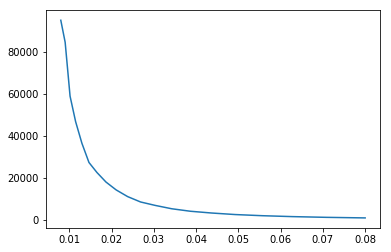

In [2]:
#RUN THIS CELL FOR DATA GENERATION
#DATA IS OUTPUT INTO FILES, SEE LATER CELLS FOR ANALYSIS
#IN GENERAL, YOU MIGHT GET SOME SET OF nan or 0 VALUES AT THE
#LONGER TIME SCALES, JUST DELETE THEM SO IT DOESN'T EFFECT THE ANALYSIS
temp = t.time()
#number of times we multiply T together
N = 500000
#number of runs (data points) per timestep
dreal = 20
#start, stop, and number of time steps
tstart = .08
tstop = .008
tsteps = 20
#the guessed values of the power law relation
ConstGuess = 4.6
PowGuess = -2.05
#the strengths of intersite and onsite disorder (uniform between -W and W)
#or coupling disorder (gaussian shift by epsilon like tau(1 + epsilon))
W = .001
onsiteW = np.pi
couplingW = 1

#time steps are equispaced or log equispaced
#tpoints = np.linspace(tstart,tstop,tsteps)
tpoints = np.logspace(np.log10(tstart),np.log10(tstop),tsteps)
loclengths = np.zeros(len(tpoints))
#a random quasieigenvalue is chosen as it does not matter but I don't want to bias the data
qEval = np.random.uniform(-np.pi,np.pi)
print(qEval)
#this defines a unique identifier for the output files
runIdent = str(t.time())[:10]

for i in range(len(tpoints)):
    #U = Unitary1(np.pi/2 - tpoints[i])
    #U = Unitary1double(np.pi/2 - tpoints[i])
    Lguess = powerlaw(tpoints[i],ConstGuess,PowGuess)
    rescale = np.exp(-2/Lguess)
    file_name1 = "lengths_T_" + str(tpoints[i]) + "0_N_" + str(N) + "_run_"+ runIdent + ".txt" 
    f1 = open(file_name1,'x')
    #file_name2 = "Tmats_T_" + str(tpoints[i]) + "0_N_" + str(N) + "_run_"+ runIdent + ".txt" 
    #f2 = open(file_name2,'x')
    for d in range(dreal):
        #Tmatrix = TpointGenerate(N,NNSublatticeDisorder(U,W),qEval)
        #Tmatrix = TpointGenerateWithOnsite(N,NNSublatticeDisorder(U,W),onsiteW,qEval)
        #Tmatrix = TpointGenerate(N,NNSublatticeDisorderT(U,W),qEval)
        #Tmatrix = TpointGenerate(N,NNSublatticeDisorderPaired(U,W),qEval)
        #Tmatrix = TpointGenerateWithOnsite(N,U,onsiteW,qEval)
        #Tmatrix = Tpoint(N,tpoints[i],onsiteW,qEval)
        #Tmatrix = Tpoint(N,tpoints[i],onsiteW,qEval,rescale)
        #Tmatrix = TpointWithCoupling(N,tpoints[i],couplingW,qEval)
        #Tmatrix = TpointWithCouplingAndRenorm(N,tpoints[i],couplingW,qEval,rescale)
        #Tmatrix = TpointWithCouplingAlt(N,tpoints[i],couplingW,qEval)
        #Tmatrix = TpointWithCouplingAlt2(N,tpoints[i],couplingW,qEval)
        #Tmatrix = TpointLongDisorder(N,tpoints[i],qEval)
        #Tmatrix = TpointLongDisorderAndRenorm(N,tpoints[i],qEval,rescale)
        #Tmatrix = TpointSimple(N,tpoints[i],onsiteW,qEval)
        Tmatrix = TpointSimple(N,tpoints[i],onsiteW,qEval,rescale)
        #f2.write(str(Tmatrix[0,0]) + "," + str(Tmatrix[0,1]) + "," + str(Tmatrix[1,0]) + "," + str(Tmatrix[1,1]) + "\n")
        #val = ((np.log(max(np.linalg.eigvalsh(np.conj(np.transpose(Tmatrix))@Tmatrix))))/(4*N))**(-1)
        val = ((np.log(max(np.linalg.eigvalsh(np.conj(np.transpose(Tmatrix))@Tmatrix))))/(4*N) + 1/Lguess)**(-1)
        f1.write(str(val) + " ")
        loclengths[i] += val / dreal
    f1.close()
    #f2.close()
print("took " + str(t.time() - temp) + " seconds.")
print(loclengths)
print(tpoints)
out, sub = plt.subplots(1)
sub = plt.plot(tpoints,loclengths)
#print(np.polyfit(np.log(tpoints),np.log(loclengths),1))

In [240]:
#run this if the above block fails to make sure the files close prozperly
f1.close()
f2.close()

(array([-1.9974835207,  0.8005618821]), array([[0.0001031312, 0.0001646912],
       [0.0001646912, 0.000272496 ]]))


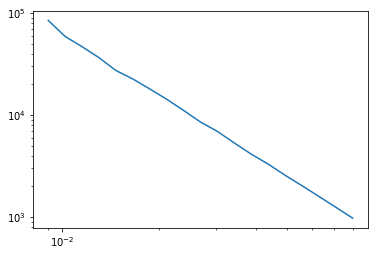

In [5]:
#this cell just allows you to look at data from the previous cell right after running
#the cut variable gives you the number of data points cut off of each end
#it does two graphs and two fits
np.set_printoptions(precision=10)
cut =-1
frontCut = 0
backCut = 0
#print((loclengths[-cut:],tpoints[-cut:]))
out, sub = plt.subplots(1)
#sub = plt.loglog(np.logspace(np.log10(.001),np.log10(.2),40)[frontCut+10:cut -8],analytics[frontCut:cut])
sub = plt.loglog(tpoints[frontCut:cut],loclengths[frontCut:cut])
print(np.polyfit(np.log10(tpoints[frontCut:]),np.log10(loclengths[frontCut:]),1,cov=True))
#print(np.polyfit(np.log10(np.logspace(np.log10(.001),np.log10(.2),40)[frontCut+10:cut -8]),np.log10(analytics[frontCut:cut]),1,cov=True))
#out, sub = plt.subplots(1)
#sub = plt.loglog(tpoints[-cut:-backCut],loclengths[-cut:-backCut])
#print(np.polyfit(np.log(tpoints[-cut:-backCut]),np.log(loclengths[-cut:-backCut]),1))
#print(np.polyfit(tpoints[-cut:],loclengths[-cut:],1))
np.set_printoptions(precision=2)

[0.2          0.1811447329 0.1640670712 0.1485994289 0.1345900193 0.1219013654 0.1104089514
 0.1          0.0905723664 0.0820335356 0.0742997145 0.0672950096 0.0609506827 0.0552044757
 0.05        ]
[-2.0609889673  0.5285665811]
[nan  0.]


C:\Users\Urrburr\Anaconda3\lib\site-packages\matplotlib\ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
C:\Users\Urrburr\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
C:\Users\Urrburr\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  


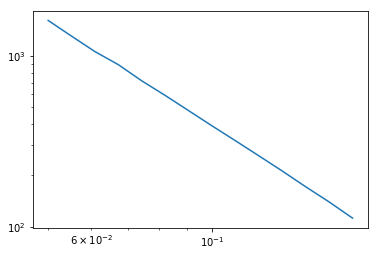

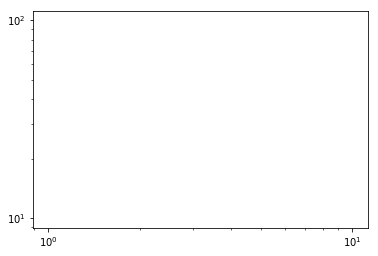

In [243]:
#this cell just allows you to look at data from the previous cell right after running
#the cut variable gives you the number of data points cut off of each end
#it does two graphs and two fits
np.set_printoptions(precision=10)
cut = len(tpoints)
frontCut = 1
backCut = -1
print(tpoints)
out, sub = plt.subplots(1)
sub = plt.loglog(tpoints[frontCut:cut],loclengths[frontCut:cut])
print(np.polyfit(np.log10(tpoints[frontCut:cut]),np.log10(loclengths[frontCut:cut]),1))
out, sub = plt.subplots(1)
sub = plt.loglog(-tpoints[-cut:-backCut],loclengths[-cut:-backCut])
print(np.polyfit(np.log(-tpoints[-cut:-backCut]),np.log(loclengths[-cut:-backCut]),1))
#print(np.polyfit(tpoints[-cut:],loclengths[-cut:],1))
np.set_printoptions(precision=2)

In [254]:
#this loads in and allows you to pull loc lengths and some analytics off of a set of files from a previous run

import glob

#runNum = #put the number here by hand if not in memory
#1548730096 #1548790415 #1548730096 #1548730096
files = glob.glob("coupling disorder/run_1556843965_N_500000/lengths*.txt")
analytics = np.zeros((len(files)))
#rawL = np.zeros((len(files),10000))
for i in range(len(files)):
    #rawL[i,:] = np.sort(np.loadtxt(files[i]))[:]
    analytics[i] = np.mean(np.loadtxt(files[i]))
    #analytics[i,0] = np.mean(rawL[i])
    #analytics[i,1] = np.std(rawL[i])
    #analytics[i,2] = np.mean(np.log(rawL[i]))
    #analytics[i,3] = np.std(np.log(raw[i]))
print(analytics)

[456123.66 447342.91 224109.36 174125.14 110032.19  92537.87  69536.68  52230.68  40469.39
  32012.58  23090.47  17319.84  13150.53  10323.16   7694.02   5816.55   4477.28   3430.15
   2606.68   1992.12   1500.32   1133.81]


In [94]:
#runNum = #put the number here by hand if not in memory
#1548730096 #1548790415 #1548730096 #1548730096
files = glob.glob("onsite disorder/run_1548730096/lengths*.txt")
stds = np.zeros((len(files)))
for i in range(len(files)):
    if not i:
        print(len(np.loadtxt(files[i])))
    stds[i] = np.std(np.loadtxt(files[i]))

10000


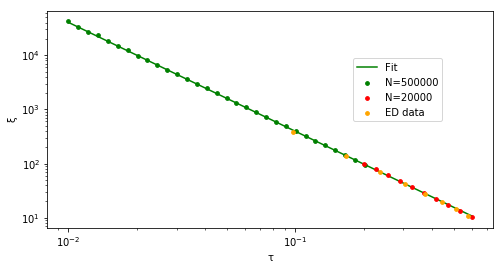

In [108]:
out, sub = plt.subplots(1,figsize=(8,4))
sub.set_ylabel("ξ")
sub.set_xlabel("τ")
sub.set_yscale('log')
sub.set_xscale('log')
#sub = plt.scatter(np.logspace(np.log10(.01),np.log10(.1),10),2*np.array([7626.24, 6087.95, 5150.31, 3641.22, 2289.88, 1690.53,  988.39,  600.19,  356.59,  211.12]),s=14,color='red')
#sub = plt.scatter(np.logspace(np.log10(.01),np.log10(.02),5),2*np.array([20091.52, 14440.54, 10089.67,  7130.04,  5131.43]),s=14,color="blue")
#sub = plt.scatter(np.logspace(np.log10(.1),np.log10(.02),7)[-3:],[3428.04,  5914.42, 10041.46],s=14,color="blue")
sub = plt.scatter(np.array([0.2027215898, 0.1833735404, 0.1658720975, 0.1500410183, 0.1357208808, 0.1227674785,
       0.1110503682, 0.1004515562, 0.0908643106, 0.0821920859, 0.0743475512, 0.0672517106,
       0.0608331075, 0.0550271055, 0.0497752368, 0.0450246144, 0.0407273983, 0.036840315 ,
       0.0333242206, 0.0301437076, 0.0272667474, 0.0246643685, 0.0223103646, 0.0201810303,
       0.0182549228, 0.0165126459, 0.0149366544, 0.013511078 , 0.0122215606, 0.0110551168,
       0.01        ]),np.array([   95.1752292998,   118.2672949958,   144.5660933804,   176.3696613603,   217.1356125444,
         265.3301776178,   322.3887160434,   397.3036594852,   485.2853023121,   589.3713427415,
         723.3723308532,   883.6466865307,  1094.027537465 ,  1312.1915608703,  1632.4749650752,
        1984.2632268647,  2439.6099286241,  2937.3397494216,  3574.2373168842,  4486.2184393535,
        5319.9075839575,  6623.067744288 ,  8005.1487212256,  9767.7756371208, 12401.7118460657,
       14634.2323237065, 18142.8277044012, 23646.8817132777, 27035.3872885892, 33125.8998027886,
       42915.3032470753]),s=14,color='green',zorder=1)
sub = plt.scatter(np.array([0.6         , 0.5310528912, 0.4700286222, 0.4160167646, 0.3682115094, 0.3258996444,
       0.2884499141, 0.2553036014, 0.2259661928, 0.2         ]), np.array([10.4224796822, 13.5106974089, 17.4346101321, 22.4103050824, 28.8274011922, 37.0318343425,
       47.4345168709, 60.7944445664, 77.9534588511, 99.233685773 ]),s=14,color="red",zorder=2)
#sub = plt.scatter([0.0695192796 ,0.0615848211, 0.0545559478, 0.0483293024 ,0.042813324  ,0.0379269019 ,0.0335981829 ,0.0297635144 ,0.026366509  ,0.0233572147 ,0.0206913808,0.0183298071 ,0.0162377674 ,0.0143844989 ,0.0127427499 ,0.0112883789, 0.01],[832.24,  1053.8,   1342.64,  1715.22,  2182.59,  2783.32,  3569.93,  4559.74,  5716.88,  7418.35,  9514.85, 11950.54, 15642.08, 20742.73, 26084.85, 32565.77, 45423.79],s=14,color='green')
#sub = plt.scatter(np.logspace(np.log10(.1),np.log10(.5),30),2*np.array([207.39, 184.5 , 164.88, 146.82, 131.18, 116.24, 104.02,  93.29,  82.96,  74.1 ,  66.36,
#        59.21,  52.84,  47.15,  42.18,  37.6 ,  33.68,  30.05,  26.88,  23.99,  21.47,  19.16,
#        17.11,  15.24,  13.63,  12.14,  10.84,   9.65,   8.61,   7.66]),s=14,color="red")
sub = plt.scatter(np.linspace(np.pi/32,np.pi/4,11)[:-3],[376.3975953725, 139.0106054988,  70.678260437,   41.9994541112,  27.7516145761 , 19.4997758327, 14.3645055149 , 10.8979120882],s=14,color="orange",zorder=4)

#sub = plt.plot(np.linspace(1,.01,2),powerlaw(np.linspace(1,.01,2),3.396,-2.116),color="orange")
#sub = plt.plot(np.linspace(1,.01,2),powerlaw(np.linspace(1,.01,2),4.01,-2.00),color="blue")
#sub = plt.plot(np.linspace(1,.01,2),powerlaw(np.linspace(1,.01,2),3.74,-2.04),color="red")
sub = plt.plot(np.linspace(.6,.01,2),powerlaw(np.linspace(.6,.01,2),3.86,-2.01),color="green",zorder=0)
#print((stds,1))
#print(np.polyfit(np.log(np.logspace(np.log10(.1),np.log10(.5),30)),np.log(2*np.array([207.39, 184.5 , 164.88, 146.82, 131.18, 116.24, 104.02,  93.29,  82.96,  74.1 ,  66.36,
#         59.21,  52.84,  47.15,  42.18,  37.6 ,  33.68,  30.05,  26.88,  23.99,  21.47,  19.16,
#         17.11,  15.24,  13.63,  12.14,  10.84,   9.65,   8.61,   7.66])),1))
out.legend(('Fit','N=500000', 'N=20000', 'ED data'),loc = (0.7,0.55))
out.savefig('DataComparison.png', dpi=400)

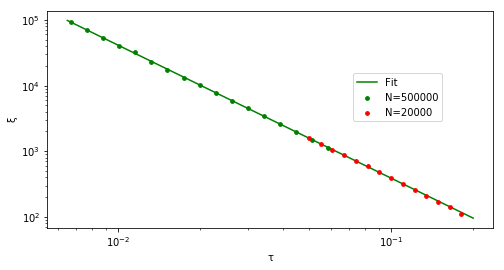

In [282]:
out, sub = plt.subplots(1,figsize=(8,4))
sub.set_ylabel("ξ")
sub.set_xlabel("τ")
sub.set_yscale('log')
sub.set_xscale('log')

sub = plt.scatter(np.logspace(np.log10(.001),np.log10(.2),40)[frontCut+9:cut -8],analytics[frontCut:],s=14,color='green',zorder=1)

sub = plt.scatter([0.1811447329, 0.1640670712, 0.1485994289, 0.1345900193, 0.1219013654 ,0.1104089514, 0.1       ,   0.0905723664, 0.0820335356 ,0.0742997145, 0.0672950096, 0.0609506827 ,0.0552044757, 0.05        ],[112.32*1000/999 , 139.76,  171.45,  212.04 , 260.34 , 319.13 , 390.11 , 479.01 , 588.13 , 716  ,  890.71, 1062.66 ,1309.26 ,1618.77],s=14,color='red',zorder=2)


sub = plt.plot(np.linspace(.2,.0065,2),powerlaw(np.linspace(.2,.0065,2),3.677,-2.024),color="green",zorder=0)

out.legend(('Fit','N=500000', 'N=20000', 'ED data'),loc = (0.7,0.55))
out.savefig('CouplingDataComparison.png', dpi=400)


In [33]:
t5x105 = tpoints
L5x105 = loclengths
cut5x105 = frontCut

In [47]:
np.set_printoptions(precision=10)
print(np.polyfit(np.log10(np.concatenate((t5x105[cut5x105:], tpoints))), np.log10(np.concatenate((L5x105[cut5x105:], loclengths))),1,cov=True))
np.set_printoptions(precision=2)

(array([-1.9761439602,  0.250476292 ]), array([[6.3208545432e-05, 1.1514260204e-04],
       [1.1514260204e-04, 2.3898216716e-04]]))


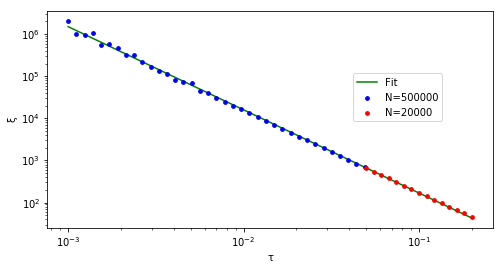

In [48]:
out, sub = plt.subplots(1,figsize=(8,4))
sub.set_ylabel("ξ")
sub.set_xlabel("τ")
sub.set_yscale('log')
sub.set_xscale('log')

sub = plt.scatter(t5x105[cut5x105:],L5x105[cut5x105:],s=14,color='blue',zorder=1)

#sub = plt.scatter([0.1811447329, 0.1640670712, 0.1485994289, 0.1345900193, 0.1219013654 ,0.1104089514, 0.1       ,   0.0905723664, 0.0820335356 ,0.0742997145, 0.0672950096, 0.0609506827 ,0.0552044757, 0.05        ],[112.32*1000/999 , 139.76,  171.45,  212.04 , 260.34 , 319.13 , 390.11 , 479.01 , 588.13 , 716  ,  890.71, 1062.66 ,1309.26 ,1618.77],s=14,color='red',zorder=2)

sub = plt.scatter(tpoints,loclengths,s=14,color='red',zorder=2)

sub = plt.plot(np.linspace(tpoints[0],t5x105[-1],2),powerlaw(np.linspace(tpoints[0],t5x105[-1],2),10**.25047,-1.976),color="green",zorder=0)

out.legend(('Fit','N=500000', 'N=20000', 'ED data'),loc = (0.7,0.55))
out.savefig('DifferentDisorderData.png', dpi=400)


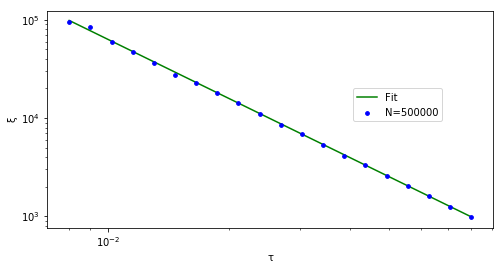

In [10]:
out, sub = plt.subplots(1,figsize=(8,4))
sub.set_ylabel("ξ")
sub.set_xlabel("τ")
sub.set_yscale('log')
sub.set_xscale('log')

sub = plt.scatter(t5x1052,L5x1052,s=14,color='blue',zorder=1)

#sub = plt.scatter([0.1811447329, 0.1640670712, 0.1485994289, 0.1345900193, 0.1219013654 ,0.1104089514, 0.1       ,   0.0905723664, 0.0820335356 ,0.0742997145, 0.0672950096, 0.0609506827 ,0.0552044757, 0.05        ],[112.32*1000/999 , 139.76,  171.45,  212.04 , 260.34 , 319.13 , 390.11 , 479.01 , 588.13 , 716  ,  890.71, 1062.66 ,1309.26 ,1618.77],s=14,color='red',zorder=2)

#sub = plt.scatter(tpoints,loclengths,s=14,color='red',zorder=2)

sub = plt.plot(np.linspace(tpoints[0],tpoints[-1],2),powerlaw(np.linspace(tpoints[0],tpoints[-1],2),10**.8,-2),color="green",zorder=0)

out.legend(('Fit','N=500000', 'N=20000', 'ED data'),loc = (0.7,0.55))
out.savefig('ToyModel.png', dpi=400)


In [8]:
t5x1052 = tpoints
L5x1052 = loclengths

In [72]:
#this loads in and allows you to pull Tmatrices and some analytics off of a set of files from a previous run

import glob

runNum = 1548730096 #1548790415 #1548730096 #1548730096 #put the number here by hand if not in memory
files = glob.glob("DISORDER TYPE/RUN NAME/T*.txt")
tsum = np.zeros((len(files),4),dtype=complex)
rawT = np.zeros((len(files),10000,4),dtype=complex)
for i in range(len(files)):
    rawT[i,:,:] = np.sort(np.loadtxt(files[i],dtype = complex,delimiter = ','))[:,:]
    tsum[i,:] = np.sum(rawT[i,:])
    #analytics[i,1] = np.std(raw[i])
    #analytics[i,2] = np.mean(np.log(raw[i]))
    #analytics[i,3] = np.std(np.log(raw[i]))


[-2.8862966   5.20231707]


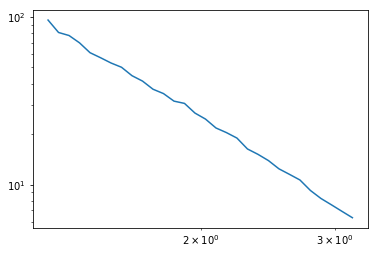

In [72]:
#an attempt at messing around with Tmatrices from files
tmatloaded = np.zeros(4)
lvals = np.zeros(len(files))
for i in range(len(files)):
    tmatloaded = tsum[i,:].reshape((2,2))
    lvals[i] = 2*2000/(np.log(max(np.linalg.eigvalsh(np.transpose(np.conjugate(tmatloaded))@tmatloaded))))
out, sub = plt.subplots(1)
sub = plt.loglog(np.logspace(.1,.5,30),lvals)
print(np.polyfit(np.log(np.logspace(.1,.5,30)),np.log(lvals),1))

[-2.04224215  0.62695367]
[-2.02880003  0.63642462]


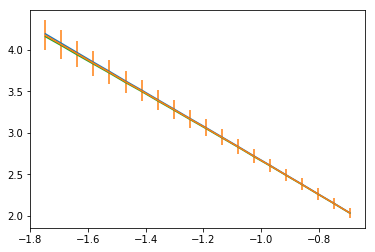

In [442]:
#additional plotting utility and trying to use error bars on loaded loclen data
#print(analytics[:,0])
#print(analytics[:,1])
tpoints = np.logspace(np.log10(.5),np.log10(.1),30)
out, sub = plt.subplots(1)
cut = 10
sub = plt.errorbar(np.log(np.flip(tpoints,0))[cut:],np.log(analytics[:,0])[cut:],yerr = None)#2*np.divide(analytics[:,1],analytics[:,0]))
sub = plt.errorbar(np.log(np.flip(tpoints,0))[cut:],analytics[:,2][cut:],yerr = analytics[:,3][cut:])
sub = plt.plot(np.log(np.flip(tpoints,0))[cut:], np.log(np.median(raw,axis=1)[cut:]))
print(np.polyfit(np.log(np.flip(tpoints,0))[cut:],np.log(analytics[:,0][cut:]),1))
print(np.polyfit(np.log(np.flip(tpoints,0))[cut:],analytics[:,2][cut:],1))

C:\Users\Urrburr\Anaconda3\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


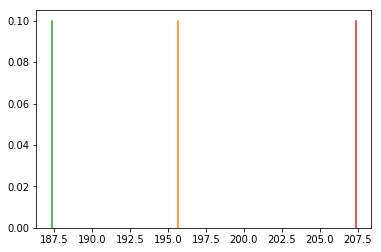

In [18]:
#looking at the distribution at a single time point
out, sub = plt.subplots()
index = 0
kay = np.exp(np.mean(np.log(raw[index])))
kayy = np.median(raw[index])
kayyy = np.mean(raw[index])
sub = plt.hist(raw[index],range=(0,70),density=True,bins=100)
maxxx = .1
sub = plt.plot([kay,kay],[0,maxxx])
sub = plt.plot([kayy,kayy],[0,maxxx])
sub = plt.plot([kayyy,kayyy],[0,maxxx])

In [12]:
#test of generic method for Tmatrices vs the existing method
tau = 1
e = 0
d = 4
w = np.pi
#phiA = np.random.uniform(0,2*np.pi)
#phiB = np.random.uniform(0,2*np.pi)
#randvect = np.array([np.exp(1j*phiA),np.exp(1j*phiB),np.exp(1j*phiA),np.exp(1j*phiB)],dtype=complex)
# U1 = np.zeros((2*d,2*d),dtype=complex)
# U2 = np.zeros((2*d,2*d),dtype=complex)
# for i in range(-d,d):
#     if not i&1:
#         U1[i,i+1] = 1j
#         U1[i+1,i] = 1j
#     if i&1:
#         U2[i,i] = np.cos(tau)
#         U2[i+1,i+1] = np.cos(tau)
#         U2[i,i+1] = -1j*np.sin(tau)
#         U2[i+1,i] = -1j*np.sin(tau)
#print(U1)
#print(U2)
#Utest = U2@U1
#print(Utest)
#U = Unitary1(np.pi - tau)
Ud = Unitary1double(np.pi - tau)
#print(U)
print(Ud)
#print(Ud-Utest)
# w = 1
# Angle = np.zeros(d)
# Phase1 = np.zeros(d)
# Phase2 = np.zeros(d)
# Phase3 = np.zeros(d)
# for i in range(d):
#     Angle[i] = np.random.uniform(-w,w)
#     Phase1[i] = np.random.uniform(-w,w)
#     Phase2[i] = np.random.uniform(-w,w)
#     Phase3[i] = np.random.uniform(-w,w)
# Ud = NNSublatticeDisorderSpecific(Ud, Angle, Phase1, Phase2, Phase3)
#print(NNSublatticeDisorderSpecific(np.eye(2*d,dtype=complex), Angle, Phase1, Phase2, Phase3))
#U = NNSublatticeDisorderSpecific(U, Angle[d//4:3*d//4], Phase1[d//4:3*d//4], Phase2[d//4:3*d//4], Phase3[d//4:3*d//4])
#print(NNSublatticeDisorderSpecific(np.eye(d,dtype=complex), Angle[d//4:3*d//4], Phase1[d//4:3*d//4], Phase2[d//4:3*d//4], Phase3[d//4:3*d//4]))
Ud = NNSublatticeDisorder(Ud,w)
Ud = Ud - np.exp(1j*e)*np.eye(len(Ud))
#U = OnsiteDisorder(U,.1)
print("U")
#print(U)
print("Udouble")
print(Ud)
#print("SVD of full U")
#print(np.linalg.svd(Ud))
#print("SVD of partial U")
#print(np.linalg.svd(Ud[d//2:3*d//2,:]))
print("Amat")
Amat = Ud[d//2:3*d//2,:d]
print(Amat)
Uamat, valsamat, Vamat = np.linalg.svd(Amat)
print("SVD of Bmat")
print((Uamat, valsamat, Vamat))
print("Attempted rank reduce")
print(Uamat[:,:-2]@np.diag(valsamat[:-2]))
print("Bmat")
Bmat = Ud[d//2:3*d//2,d:]
print(Bmat)
Ubmat, valsbmat, Vbmat = np.linalg.svd(Bmat)
print("SVD of Bmat")
print((Ubmat, valsbmat, Vbmat))
print("Attempted Tmat")
Tmat = np.linalg.pinv(Bmat)@Amat
print(Tmat)
print("rank of attempyted Tmat")
print(np.linalg.matrix_rank(Tmat))
print("SVD of attempted Tmat")
Utmat, valstmat, Vtmat = np.linalg.svd(Tmat)
print((Utmat, valstmat, Vtmat))
#way2 = generateTmat(Ud,e)
#way1 = generateTmat(U,e)
#print("way1")
#print(way1)
#print(np.linalg.det(way1))
#print("way2")
#print(way2)
#print(np.linalg.det(way2))
#M1 = np.conj(np.transpose(way1))@way1
#M2 = np.conj(np.transpose(way2))@way2
#print(M)
# print("M1")
# print(np.linalg.det(M1))
# print(np.linalg.eigvalsh(M1))
#print("M2")
#print(np.linalg.det(M2))
#print(np.linalg.eigvalsh(M2))
#print("compare")
#print(way1-way2)
#print(M1-M2)

[[0.  +0.  j 0.  -0.54j 0.  +0.  j 0.  +0.  j 0.  +0.  j 0.  +0.  j 0.84+0.  j 0.  +0.  j]
 [0.  -0.54j 0.  +0.  j 0.  +0.  j 0.84+0.  j 0.  +0.  j 0.  +0.  j 0.  +0.  j 0.  +0.  j]
 [0.84+0.  j 0.  +0.  j 0.  +0.  j 0.  -0.54j 0.  +0.  j 0.  +0.  j 0.  +0.  j 0.  +0.  j]
 [0.  +0.  j 0.  +0.  j 0.  -0.54j 0.  +0.  j 0.  +0.  j 0.84+0.  j 0.  +0.  j 0.  +0.  j]
 [0.  +0.  j 0.  +0.  j 0.84+0.  j 0.  +0.  j 0.  +0.  j 0.  -0.54j 0.  +0.  j 0.  +0.  j]
 [0.  +0.  j 0.  +0.  j 0.  +0.  j 0.  +0.  j 0.  -0.54j 0.  +0.  j 0.  +0.  j 0.84+0.  j]
 [0.  +0.  j 0.  +0.  j 0.  +0.  j 0.  +0.  j 0.84+0.  j 0.  +0.  j 0.  +0.  j 0.  -0.54j]
 [0.  +0.  j 0.84+0.  j 0.  +0.  j 0.  +0.  j 0.  +0.  j 0.  +0.  j 0.  -0.54j 0.  +0.  j]]
U
Udouble
[[-1.  +0.  j  0.06+0.45j  0.  +0.  j -0.17-0.23j -0.09+0.13j  0.  +0.  j -0.76-0.33j  0.  +0.  j]
 [ 0.21-0.35j -0.83-0.42j  0.27-0.23j -0.08-0.71j  0.  +0.  j  0.  +0.  j  0.  +0.  j  0.  +0.  j]
 [ 0.54+0.33j -0.27-0.11j -0.64+0.42j -0.45+0.05j  0.  +0.  j  

In [29]:
#this cell is for testing
N = 50000
tau = .001

U = Unitary1(np.pi/2 - tau)
Tmatrix = TpointGenerate(N,NNSublatticeDisorder(U,.01),0)
print(Tmatrix)
print(np.conj(np.transpose(Tmatrix))@Tmatrix)
evals = np.linalg.eigvalsh(np.conj(np.transpose(Tmatrix))@Tmatrix)
print(evals)
print(2*N/(np.log(max(evals))))

svals = np.linalg.svd(np.conj(np.transpose(Tmatrix))@Tmatrix,compute_uv = False)
print(svals)
print(2*N/(np.log(max(svals))))

#print(logm(np.conj(np.transpose(Tmatrix))) + logm(Tmatrix))
#print(logm(np.conj(np.transpose(Tmatrix))@Tmatrix))
temp = logm(Tmatrix)
print(logm(Tmatrix))
print(expm(temp))
#print(2*N/max(np.absolute(np.linalg.eigvalsh(logm(np.conj(np.transpose(Tmatrix))) + logm(Tmatrix)))))
print(2*N/(np.absolute(np.linalg.eigvals(logm(Tmatrix)))))
#print(N/np.absolute())

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01

[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01

[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e

Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00

[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-

 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00

Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+

[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e-03j]]
Amat
[[-7.85e-07+1.00e-03j -9.92e-01-4.75e-05j]
 [ 1.00e+00+7.85e-04j  4.75e-08+7.83e-06j]]
Bmat
[[-7.12e-08-6.54e-06j -1.00e+00-9.39e-03j]
 [ 9.93e-01+7.12e-05j  9.39e-06-1.00e

KeyboardInterrupt: 

In [46]:
U = NNSublatticeDisorder(np.eye(8,dtype=complex),.1)
print(U)
print(np.linalg.det(U))
print(np.transpose(np.conjugate(U))@U)

[[ 1.00000000e+00+8.83513471e-06j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -5.56667056e-07-2.73937006e-12j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  1.00000000e+00-9.08481128e-06j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -1.74020984e-07+3.10700809e-13j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.00000000e+00-7.43618382e-06j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   9.70592581e-06-7.92222991e-11j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  1.00000000e+00+2.32497303e-07j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00